# Recurrence Quantification Analysis

In [1]:
import importlib

# List of libraries to check
libraries = [
    'numpy',
    'matplotlib',
    'scipy',
    'torch',
    'torchdiffeq',
    'torchsummary',
    'minepy',
    'pyrqa',
    'pyts',
    'MFDFA',
    'pyinform',
    'graphviz',
    'fa2',
    'networkx'
]

for lib in libraries:
    try:
        module = importlib.import_module(lib)
        version = getattr(module, '__version__', 'Unknown version')
        print(f'{lib}: {version}')
    except ImportError:
        print(f'{lib} is not installed.')

numpy: 1.24.3
matplotlib: 3.7.0
scipy: 1.10.1
torch: 2.0.1+cu117
torchdiffeq: 0.2.3
torchsummary: Unknown version
minepy: b'1.2.6'
pyrqa: Unknown version
pyts: 0.12.0
MFDFA: 0.4.3
pyinform: Unknown version
graphviz: 0.20.1
fa2 is not installed.
networkx: 3.0


### 2D Recurrence Quantification

In [ ]:
import numpy as np
import os
import pandas as pd
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RQAComputation
from pyrqa.time_series import TimeSeries
from pyrqa.metric import EuclideanMetric
import zipfile


eeg_channels = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

zipped_file_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Space/2dembedded_data.zip'
output_directory = '/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Recurrence Quantification'

def apply_channel_computation(args):
    return compute_rqa_for_channel(*args)

def compute_rqa_for_channel(channel_data, channel_name):
    time_series = TimeSeries(channel_data, embedding_dimension=2, time_delay=1)
    settings = Settings(time_series, neighbourhood=FixedRadius(0.1), similarity_measure=EuclideanMetric(), theiler_corrector=1)
    computation = RQAComputation.create(settings)
    rqa_result = computation.run()
    
    metrics = {
        "RR": rqa_result.recurrence_rate,
        "DET": rqa_result.determinism,
        "LAM": rqa_result.laminarity,
        "L": rqa_result.average_diagonal_line,
        "Lmax": rqa_result.longest_diagonal_line,
        "L_entr": rqa_result.entropy_diagonal_lines,
        "TT": rqa_result.trapping_time,
        "RT": rqa_result.recurrence_time,
        "TREND": rqa_result.trend,
        "DET/RR": rqa_result.determinism / rqa_result.recurrence_rate if rqa_result.recurrence_rate != 0 else 0
    }
    
    return channel_name, metrics

embedded_data = {}
with zipfile.ZipFile(zipped_file_path, 'r') as zipf:
    for channel in eeg_channels:
        data_file_name = f'2dembedded_{channel}_data.npy'
        with zipf.open(data_file_name) as data_file:
            embedded_data[channel] = np.load(data_file)

channels_with_data = [(embedded_data[channel], channel) for channel in eeg_channels]

results = []
for channel_data, channel_name in [(embedded_data[channel], channel) for channel in eeg_channels]:
    try:
        results.append(compute_rqa_for_channel(channel_data, channel_name))
    except Exception as e:
        print(f"An error occurred with channel {channel_name}: {e}")

if results:
    flattened_results = [(channel, *metrics.values()) for channel, metrics in results]
    df_columns = ['Channel', 'RR', 'DET', 'LAM', 'L', 'Lmax', 'L_entr', 'TT', 'RT', 'TREND', 'DET/RR']
    df = pd.DataFrame(flattened_results, columns=df_columns)
    csv_path = os.path.join(output_directory, "rqa_results.csv")
    df.to_csv(csv_path, index=False)
    print("RQA analysis results saved in", csv_path)
else:
    print("No results to save.")

An error occurred with channel Fp1: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### Load 3D embedded from zip

In [ ]:
import zipfile
import numpy as np
import os

# Define the path to the zipped file
zip_file_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Space/3dembedded_data.zip'

# Directory to temporarily extract the numpy files
temp_extract_dir = '/home/vincent/temp_embedded_data/'

# Check if the temp directory exists, if not create it
if not os.path.exists(temp_extract_dir):
    os.mkdir(temp_extract_dir)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(temp_extract_dir)

# Load each numpy file and store them in a dictionary for easy access
embedded_data_dict = {}

for channel in eeg_channels:
    data_file_path = os.path.join(temp_extract_dir, f'3dembedded_{channel}.npy')
    embedded_data_dict[channel] = np.load(data_file_path)

# Optionally, remove the extracted .npy files to clean up after loading
for channel_file in os.listdir(temp_extract_dir):
    os.remove(os.path.join(temp_extract_dir, channel_file))

# Remove the temporary directory
os.rmdir(temp_extract_dir)

# Now, embedded_data_dict contains the loaded numpy arrays for each channel

### 3D Recurrence Quantification

In [ ]:
import numpy as np
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RQAComputation
from pyrqa.image_generator import ImageGenerator
from pyrqa.result import RQAResult
from pyrqa.time_series import TimeSeries
from pyrqa.metric import EuclideanMetric
from concurrent.futures import ThreadPoolExecutor

# Load the 3D embedding data for all EEG channels
eeg_channels = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

embedding_data_directory = '/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Space/3dembedding_data'
embedding_data_list = []

for channel in eeg_channels:
    embedded_channel_data = np.load(f'{embedding_data_directory}/3dembedded_{channel}_data.npy')
    embedding_data_list.append(embedded_channel_data)

# Convert the embedded data into TimeSeries type for each channel
time_series_list = []

for channel_data in embedding_data_list:
    time_series_x = TimeSeries(channel_data[:, 0], embedding_dimension=1)
    time_series_y = TimeSeries(channel_data[:, 1], embedding_dimension=1)
    time_series_z = TimeSeries(channel_data[:, 2], embedding_dimension=1)
    time_series_list.append((time_series_x, time_series_y, time_series_z))

# RQA settings
radius = 0.5  # Adjust this based on your data's characteristics

def compute_rqa_for_channel(channel_time_series_data):
    channel, time_series_tuple = channel_time_series_data

    settings = Settings(time_series_tuple,
                        neighbourhood=FixedRadius(radius),
                        similarity_measure=EuclideanMetric(),
                        theiler_corrector=1)

    # Compute RQA
    computation = RQAComputation.create(settings)
    result = computation.run()

    # Print RQA results
    print(f"RQA results for {channel}:\n{result}")

    # Generate a recurrence plot
    ImageGenerator.save_recurrence_plot(result.recurrence_matrix_reverse,
                                        f'{embedding_data_directory}/plots/recurrence_plot_{channel}.png')
    return result

# Using thread-based parallel processing to compute RQA for each channel
with ThreadPoolExecutor() as executor:
    rqa_results = list(executor.map(compute_rqa_for_channel, zip(eeg_channels, time_series_list)))

print("RQA analysis and recurrence plots saved for all EEG channels.")

In [6]:
import mne
import numpy as np

# Load EEG data
EEGdata = np.load('/home/vincent/AAA_projects/MVCS/Neuroscience/eeg_data_with_channels.npy', allow_pickle=True)

# EEG channel names (hardcoded from previous code snippet)
eeg_channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                     'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                     'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

# Transpose the EEG data if necessary
if EEGdata.shape[0] != len(eeg_channel_names):
    EEGdata = EEGdata.T
    
sfreq = 1000  # Your sampling frequency

ch_types = ['eeg'] * len(eeg_channel_names)
info = mne.create_info(ch_names=eeg_channel_names, sfreq=sfreq, ch_types=ch_types)

# Create Raw object
raw = mne.io.RawArray(EEGdata, info)

# Apply band-pass filter
raw.filter(l_freq=1., h_freq=50.)

# Standardize data (mean 0, variance 1)
raw_standardized = (raw.get_data() - np.mean(raw.get_data())) / np.std(raw.get_data())

# If your data have multiple channels and you want to use RQA on each channel separately,
# you should split your data here
eeg_data_split = np.split(raw_standardized, len(eeg_channel_names), axis=0)

# Now 'eeg_data_split' is a list of 1D numpy arrays, each one representing a channel
# You can now use these arrays as inputs for your RQA computations

Creating RawArray with float64 data, n_channels=32, n_times=4227788
    Range : 0 ... 4227787 =      0.000 ...  4227.787 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    1.9s finished


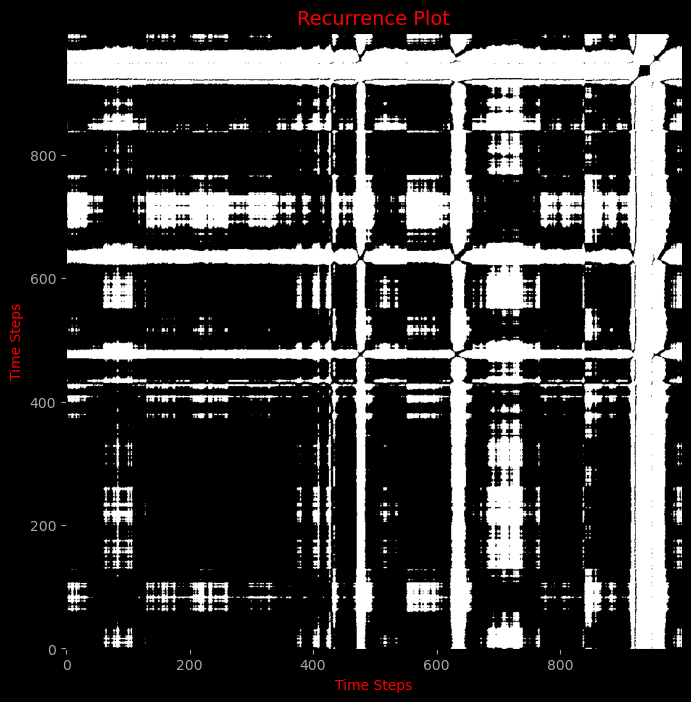

In [25]:
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot

# Downsample factor
downsample_factor = 10  # Further downsample the data

# Select a segment of the data
start_time = 1  # Adjust these to your needs
end_time = 10000

# Downsample the data and select a segment
downsampled_channel_data = EEGdata[0, start_time:end_time:downsample_factor]

# Create a RecurrencePlot object
rp = RecurrencePlot(dimension=embedding_dimension, time_delay=time_delay, threshold='distance')

# Transform the time series into a Recurrence Plot
X_rp = rp.fit_transform(downsampled_channel_data.reshape(1, -1))

# Plot the result
fig, ax = plt.subplots(figsize=(8, 8))

# Set black background
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Draw the recurrence plot
im = ax.imshow(X_rp[0], cmap='binary', origin='lower')

# Set title and labels with red color
ax.set_title('Recurrence Plot', fontsize=14, color='red')
ax.set_xlabel('Time Steps', color='red')
ax.set_ylabel('Time Steps', color='red')

# Change ticks color to dark grey
ax.tick_params(colors='darkgrey')

# Show the plot
plt.show()